<a href="https://colab.research.google.com/github/ColinLee2004/California-Lawmakers-EDA-and-Predictions/blob/main/Colin_Lee_Lawmakers_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


The dataset comes from the **Digital Democracy Project**, a joint endeavor of a research team I am a part of and
CalMatters, a California-based non-profit journalism outfit specializing on Calfifornia state politics.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

In [3]:
filename_activity = 'https://raw.githubusercontent.com/digitaldemocracy/ds112/main/CA_lawmaker_activity_2023.csv'
filename_ideology = 'https://raw.githubusercontent.com/digitaldemocracy/ds112/main/CA_lawmaker_ideologies.csv'
filename_alignments = 'https://raw.githubusercontent.com/digitaldemocracy/ds112/main/new_alignments.csv'

In [4]:
df_ac = pd.read_csv(filename_activity)
df_id = pd.read_csv(filename_ideology)[['pid', 'ideology']]
df_al = pd.read_csv(filename_alignments)

In [5]:
df_ac.head(3)

,pid,activity_score,num_min_speaking,session_year
0,10,77,77,2023
1,11,36,36,2023
2,16,206,206,2023




* `pid`: the unique Id of a person in the Digital Democracy database.
* `activity_score` and `num_min_speaking` are basically representing the same information - the total number of minutes the Lawmaker spoke in different legislative hearings during the 2023-2024 legislative session (to date).
* `session_year`: is set to 2023 (so can be ignored)

In [6]:
df_id.head(3)

,pid,ideology
0,2,-0.878362
1,7,-0.948147
2,8,-0.792439



* `pid`: the Digital Democracy id of a person - all the ids in this data frame are current or former California State Legislators.

* `ideology`: The ideology of the Legislator. This is a value in the range `[-1, +1]`.  This scoring system assigns `-1` as the "most liberal" ideology score and `+1` as the "most conservative" ideology score

In [7]:
df_al.head(3)

,Unnamed: 0,pid,lastName,firstName,Chamber,District,Party,American Civil Liberties Union of California,"American Federation of State, County and Municipal Employees (AFSCME)",Bay Area Council,...,Legal Services for Prisoners,National Resources Defense Council,Oakland Privacy,Peace Officers Research Association Of California,Planned Parenthood,Rural Counties Representatives of California,San Francisco Public Defender,Service Employees International Union (SEIU),Sierra Club California,Western Center on Law and Poverty
0,0,10,Lackey,Tom,Assembly,34,Republican,0.329524,0.593156,0.767857,...,0.335664,0.504587,0.388060,0.937716,0.600000,0.808383,0.322034,0.418605,0.461957,0.569444
1,1,11,Low,Evan,Assembly,26,Democrat,0.736486,0.958159,0.821429,...,0.694268,0.923077,0.866667,0.864865,0.991453,0.817460,0.794872,0.916667,0.888889,0.988024
2,2,16,Irwin,Jacqui,Assembly,42,Democrat,0.609053,0.977273,0.788462,...,0.580357,0.903509,0.825000,0.865385,0.971429,0.852713,0.621622,0.888372,0.858824,0.941176


The relevant columns are:

* `pid`: same as in the other two data frames, the Digital Democracy Id of a person. Here, we have ids of 120 2023-2024 California State Legislators.

* `lastName`, `firstName`: the name of the lawmaker

* `Chamber`: either `Assembly` or `Senate`.

* `District`: the legislative district the lawmaker represents. Senate districts go 1-40, Assembly districts - 1-80.

* `Party`: `Republican` or `Democrat` - the party affiliation of the lawmaker.
* `American Civil Liberties Union of California` ... `Western Center of Law and Poverty`: 0 = least alligned. 1 = most alligned

In [8]:
df_al.columns[7:]

Index(['American Civil Liberties Union of California',
       'American Federation of State, County and Municipal Employees (AFSCME)',
       'Bay Area Council', 'California Apartment Association',
       'California Association Of Realtors', 'California Catholic Conference',
       'California Chamber of Commerce',
       'California Chapter National Association of Social Workers',
       'California District Attorneys Association',
       'California Environmental Voters', 'California Faculty Associaiton',
       'California Housing Partnership', 'California Immigrant Policy Center',
       'California Labor Federation',
       'California Manufacturers And Technology Association',
       'California Medical Association', 'California Nurses Association',
       'California Pan-Ethnic Health Network',
       'California Professional Firefighters', 'California Public Defenders',
       'California School Employees Association',
       'California Sheriffs Association',
       'Californ

In [9]:
df_al.loc[:, "American Civil Liberties Union of California":"Western Center on Law and Poverty"] # These are all the columns for the different organizations.

,American Civil Liberties Union of California,"American Federation of State, County and Municipal Employees (AFSCME)",Bay Area Council,California Apartment Association,California Association Of Realtors,California Catholic Conference,California Chamber of Commerce,California Chapter National Association of Social Workers,California District Attorneys Association,California Environmental Voters,...,Legal Services for Prisoners,National Resources Defense Council,Oakland Privacy,Peace Officers Research Association Of California,Planned Parenthood,Rural Counties Representatives of California,San Francisco Public Defender,Service Employees International Union (SEIU),Sierra Club California,Western Center on Law and Poverty
0,0.329524,0.593156,0.767857,0.825000,0.885057,0.713483,0.841004,0.608856,0.935897,0.391304,...,0.335664,0.504587,0.388060,0.937716,0.600000,0.808383,0.322034,0.418605,0.461957,0.569444
1,0.736486,0.958159,0.821429,0.755814,0.764706,0.887218,0.467213,0.990783,0.757709,0.985294,...,0.694268,0.923077,0.866667,0.864865,0.991453,0.817460,0.794872,0.916667,0.888889,0.988024
2,0.609053,0.977273,0.788462,0.763441,0.727273,0.832000,0.477099,0.946602,0.889571,1.000000,...,0.580357,0.903509,0.825000,0.865385,0.971429,0.852713,0.621622,0.888372,0.858824,0.941176
3,0.756335,0.972892,0.794118,0.718447,0.696203,0.900862,0.370149,0.997658,0.697674,0.972603,...,0.764706,0.937107,0.924242,0.759615,0.996875,0.815476,0.833333,0.960000,0.865672,0.976190
4,0.434524,0.540342,0.781818,0.747525,0.755102,0.830189,0.783838,0.704434,0.858268,0.468750,...,0.400000,0.514563,0.479167,0.877095,0.569061,0.823293,0.239130,0.378440,0.494737,0.648794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.560976,0.921053,0.729730,0.873684,0.534884,0.887097,0.419118,1.000000,0.757576,0.987805,...,0.655738,0.957447,0.803279,0.851240,0.978261,0.588235,0.655172,0.940594,0.950820,0.916667
116,0.793103,1.000000,0.672727,0.805195,0.729730,0.866667,0.366197,1.000000,0.775281,1.000000,...,0.844156,1.000000,0.940000,0.836066,1.000000,0.685185,0.875000,0.993007,0.986842,0.968421
117,0.306358,0.686567,0.676471,0.918919,0.863636,0.773333,0.845361,0.763441,0.953846,0.526316,...,0.402439,0.428571,0.562500,0.971098,0.972973,0.888889,0.344633,0.585366,0.484375,0.695652
118,0.375000,0.489362,0.657895,0.800000,0.909091,0.700000,0.848837,0.562500,0.934783,0.549296,...,0.439024,0.285714,0.666667,0.947368,0.640000,0.920000,0.411765,0.358491,0.459459,0.522727


In [10]:
df_al_pid = df_al.set_index('pid')
df_id_pid = df_id.set_index('pid')
df_ac_pid = df_ac.set_index('pid')
joint = df_al_pid.join(df_id_pid, on='pid').loc[:,"American Civil Liberties Union of California":"ideology"]

Lets perform some EDA on the dataset before we get into predicting ideology.

First lets look at the relationships between each of the organizations and the ideology column.

In [11]:
corrs = joint.corr()['ideology'].sort_values(ascending = False)
corrs

,ideology
ideology,1.000000
California Manufacturers And Technology Association,0.928724
California Chamber of Commerce,0.920729
California Sheriffs Association,0.829894
California District Attorneys Association,0.735138
California Special Districts Association,0.679100
California Association Of Realtors,0.650044
Peace Officers Research Association Of California,0.626572
League Of California Cities,0.603718
California State Association Of Counties,0.595610


In [12]:
# Lets graph the a scatterplot of ideology vs 3 different organizations,
# One with a strong, negative correlation
# One with a strong, positive correlation
# And one with a weak correlation.
def show_corr(org):
  plt.scatter(x = joint.ideology, y = joint[org])
  plt.xlabel("ideology score")
  plt.ylabel("Alignment with " + org)
  plt.title("Ideology vs. " + org)

Correlation coefficient between CMATA and Ideology: 0.9287


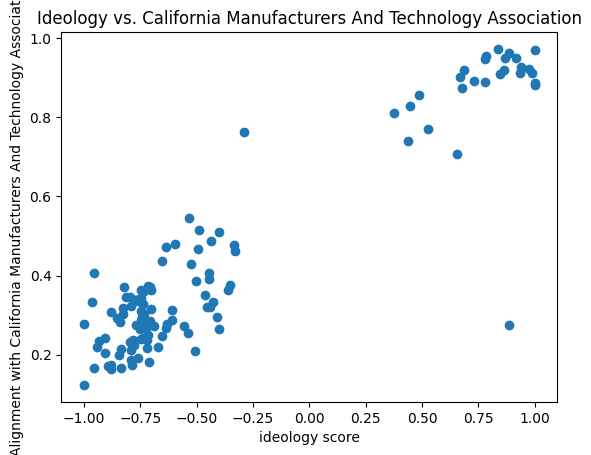

In [13]:
# The allignments with the 'California Manufacturers And Technology Association' have a
# strong, positive correlation with ideology.
fig = plt.figure()
show_corr('California Manufacturers And Technology Association')
fig.show()
print('Correlation coefficient between CMATA and Ideology: 0.9287')

Correlation coefficient between Friends Committee on Legislation in California & Ideology: -0.937


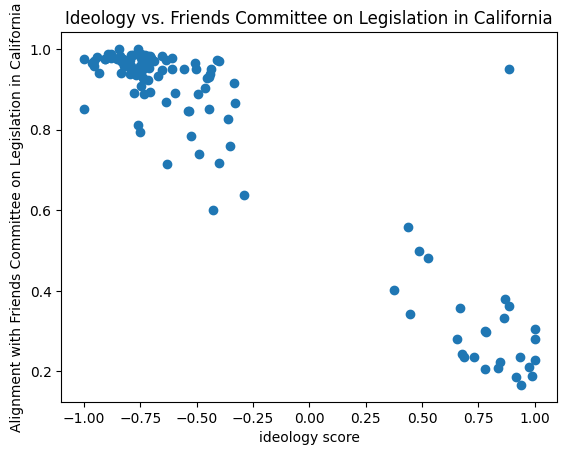

In [14]:
# The allignments with the 'Friends Committee on Legislation in California' have a
# strong, negative correlation with ideology.

fig2 = plt.figure()
show_corr("Friends Committee on Legislation in California")
fig2.show()
print('Correlation coefficient between Friends Committee on Legislation in California & Ideology: -0.937')

Correlation coefficient between Bay Area Council & Ideology: 0.083


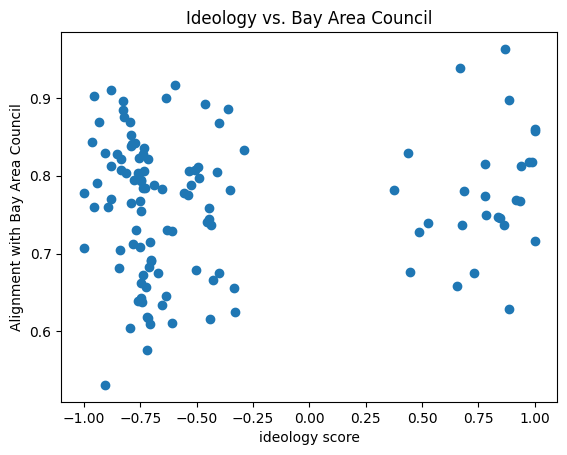

In [15]:
# The allignments with the 'Friends Committee on Legislation in California' have a
# weak correlation with ideology.
fig3 = plt.figure()
show_corr('Bay Area Council')
fig3.show()
print('Correlation coefficient between Bay Area Council & Ideology: 0.083')

Analysis:
Most organizations have a decently strong correlation with Ideology. Only 2 out of the 42 organizations have a absolute value of Correlation Coeficcient with Ideology of less than 0.5. My interpretation of this is that there aren't many neutral organizations, they tend to lean towards one political ideology.

In [16]:
# Here, lets try to find the best combination of 2 organizations to predict ideology
# using a K-Nearest-Neighbors Regressor.
from itertools import combinations
from sklearn.model_selection import cross_val_score

all_orgs = df_al.columns[7:]

k13 = KNeighborsRegressor(
    n_neighbors = 13,
    metric = 'euclidean'
)

k13_pipeline = make_pipeline(
    k13
)

accuracies = {}
for features in combinations(all_orgs, 2):
  feature_string = ",".join(features)
  # estimate test error for a model with the given features
  accuracies[feature_string] = - cross_val_score(
    k13_pipeline,
    X=joint[list(features)], y=joint.ideology,
    scoring='neg_mean_squared_error',
    cv=10).mean()

k_accuracies_sorted = pd.Series(accuracies).sort_values(ascending = True)
k_accuracies_sorted

,0
"California District Attorneys Association,Western Center on Law and Poverty",0.035952
"California Chapter National Association of Social Workers,California District Attorneys Association",0.036830
"California District Attorneys Association,California Housing Partnership",0.037188
"California Sheriffs Association,Western Center on Law and Poverty",0.037248
"California District Attorneys Association,Children Now",0.038306
...,...
"Bay Area Council,Rural Counties Representatives of California",0.269888
"California Apartment Association,League Of California Cities",0.272733
"Bay Area Council,California State Association Of Counties",0.276127
"California Apartment Association,California State Association Of Counties",0.284974


In [17]:
k_best_2_features = ['California District Attorneys Association', 'Western Center on Law and Poverty']

In [18]:
# Lets do the same thing but using Linear Regression instead.
all_orgs = df_al.columns[7:]

lin3 = LinearRegression()

lin_pipeline = make_pipeline(
    lin3
)

accuracies = {}
for features in combinations(all_orgs, 2):
  feature_string = ",".join(features)
  # estimate test error for a model with the given features
  accuracies[feature_string] = - cross_val_score(
    lin_pipeline,
    X=joint[list(features)], y=joint.ideology,
    scoring='neg_mean_squared_error',
    cv=10).mean()

lin_accuracies_sorted = pd.Series(accuracies).sort_values(ascending = True)
lin_accuracies_sorted

,0
"California Manufacturers And Technology Association,Western Center on Law and Poverty",0.043889
"California Manufacturers And Technology Association,Friends Committee on Legislation in California",0.044774
"California District Attorneys Association,Friends Committee on Legislation in California",0.045583
"California Chapter National Association of Social Workers,California District Attorneys Association",0.045831
"California District Attorneys Association,Western Center on Law and Poverty",0.046111
...,...
"California Apartment Association,California State Association Of Counties",0.273493
"Bay Area Council,California State Association Of Counties",0.274361
"California Apartment Association,Rural Counties Representatives of California",0.278005
"Bay Area Council,Rural Counties Representatives of California",0.296895


In [19]:
lin_best_2_features = ['California Manufacturers And Technology Association','Western Center on Law and Poverty']

In [20]:
# Using the 2 best features for each type of regressor, lets train and report
# the MSE for each type of model.
X_train, X_test, y_train, y_test = train_test_split(joint.loc[:, "American Civil Liberties Union of California":"Western Center on Law and Poverty"],
                                                    joint.ideology, test_size=0.2, random_state=41)
best_lin = LinearRegression()
best_linear_pipeline = make_pipeline(
    best_lin
)

best_linear_pipeline.fit(X_train[lin_best_2_features], y_train)
lin_predictions2 = best_linear_pipeline.predict(X_test[lin_best_2_features])

lin_mse = mean_squared_error(y_test, lin_predictions2)

best_k = KNeighborsRegressor(metric = 'euclidean', n_neighbors = 13)
best_k_pipeline = make_pipeline(
    best_k
)

best_k_pipeline.fit(X_train[k_best_2_features], y_train)
k_predictions2 = best_k_pipeline.predict(X_test[k_best_2_features])
k_mse = mean_squared_error(y_test, k_predictions2)

print('MSE of Linear Regression:', str(lin_mse))
print('MSE of K-Neighbors Regression:', str(k_mse))

MSE of Linear Regression: 0.1390825432261863
MSE of K-Neighbors Regression: 0.10448817309219993


The K neighbors regressor using the best combination of any 2 features has a lower MSE than the linear regression model using the best combination of any 2 features.

In [21]:
print("features for k-neighbors regressor", k_best_2_features)
print("features for linear regressor", lin_best_2_features)

features for k-neighbors regressor ['California District Attorneys Association', 'Western Center on Law and Poverty']
features for linear regressor ['California Manufacturers And Technology Association', 'Western Center on Law and Poverty']


In [22]:
# Now let's predict activity_score.
al_ac_joint = df_al_pid.join(df_ac_pid, on='pid')
al_ac_joint_for_corr = al_ac_joint.loc[:, "American Civil Liberties Union of California":"activity_score"]



In [23]:
al_ac_joint_for_corr.corr()['activity_score'].sort_values(ascending = False)


,activity_score
activity_score,1.000000
Bay Area Council,0.287589
Legal Services for Prisoners,0.232083
Friends Committee on Legislation in California,0.223099
California Catholic Conference,0.219078
California Chapter National Association of Social Workers,0.210835
California Pan-Ethnic Health Network,0.204122
Western Center on Law and Poverty,0.202970
National Resources Defense Council,0.201677
Ella Baker Center For Human Rights,0.189788


Most neutral correlation: Correlation coefficient between SF Public Defender and Activity: -0.0286


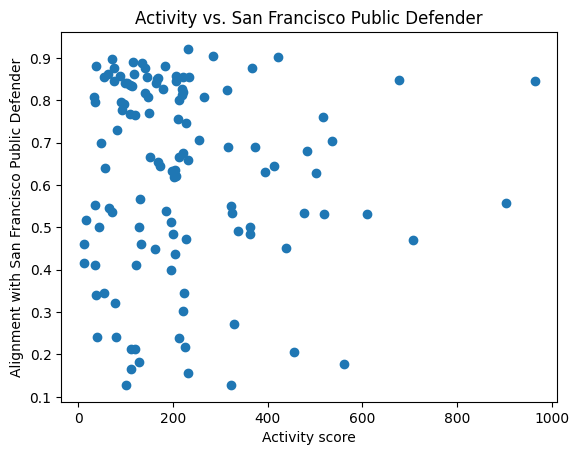

In [24]:
# As shown above, there is not a single organization that has a strong
# relationship with activity score.

# Let's visualize the organization with the most neutral correlation.
def show_activity_corr(org):
  plt.scatter(x = al_ac_joint_for_corr.activity_score, y = joint[org])
  plt.xlabel("Activity score")
  plt.ylabel("Alignment with " + org)
  plt.title("Activity vs. " + org)

fig4 = plt.figure()
show_activity_corr('San Francisco Public Defender')
fig4.show()
print('Most neutral correlation: Correlation coefficient between SF Public Defender and Activity: -0.0286')

Most positive correlation: Correlation coefficient between Bay Area Council and Activity: 0.2876


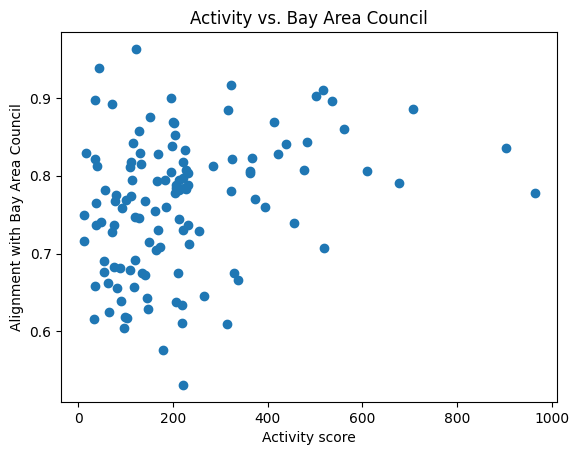

In [25]:
# Now let's visualize the organization with the most positive correlation.
fig5 = plt.figure()
show_activity_corr('Bay Area Council')
fig5.show()
print('Most positive correlation: Correlation coefficient between Bay Area Council and Activity: 0.2876')

Most negative correlation: Correlation coefficient between Peace Officers Research Association Of California and Activity: -0.3409


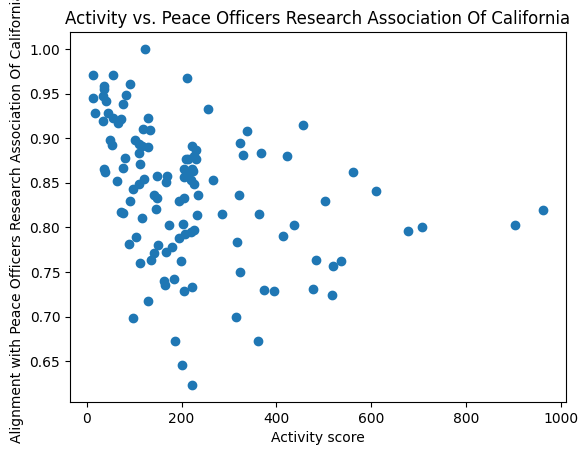

In [26]:
# Finally, let's visualize the organization with the most negative correlation.
fig6 = plt.figure()
show_activity_corr('Peace Officers Research Association Of California')
fig6.show()
print('Most negative correlation: Correlation coefficient between Peace Officers Research Association Of California and Activity: -0.3409')

Analysis: There is not a single organization that has a strong correlation with Activity

In [27]:
# To show the effects of regressing using 1) too many features and 2) features that
# have a low correlation with the target variable, let's find the best metrics
# for a K-Nearest-Neighbors Regressor using GridSearchCv.
X_train, X_test, y_train, y_test = train_test_split(al_ac_joint_for_corr.loc[:, "American Civil Liberties Union of California":"Western Center on Law and Poverty"],
                                                    al_ac_joint_for_corr.activity_score, test_size=0.2, random_state=41)


grid = GridSearchCV(
    ### estimator ,
    estimator = KNeighborsRegressor(),
    param_grid = {'n_neighbors': range(1,20),
                  'metric': ['euclidean', 'manhattan']},
    scoring = 'neg_mean_squared_error',
    cv = 10,
)

###
grid.fit(
    ### place the right values here
    X_train, y_train
   )

###  Now, let's recover the best parameters
print(grid.best_params_)
best_k = grid.best_estimator_
-grid.best_score_


{'metric': 'manhattan', 'n_neighbors': 6}


20185.038641975312

In [28]:
# Now let's do the same with a linear regressor
# this one will be much simpler because there aren't any
# parametrers to change.
lin_grid = GridSearchCV(
    ### estimator ,
    estimator = LinearRegression(),
    param_grid={},
    scoring = 'neg_mean_squared_error',
    cv = 10,
)

lin_grid.fit(
    ### place the right values here
    X_train, y_train
   )

###  Now, let's recover the best parameters
best_lin = lin_grid.best_estimator_
-lin_grid.best_score_

43990.92055142618

Analysis: The KNN model is twice as good as the linear regression model. However, we are getting worse results than when I was predicting ideology